In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import h5py
from matplotlib import pyplot as plt
from matplotlib.path import Path
import matplotlib.ticker as ticker
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.kernel_ridge import KernelRidge
import scipy
from scipy.constants import physical_constants

In [3]:
def h5group_to_dict(grp):
    dct = {}
    for key, val in grp.items():
        if isinstance(val, h5py.Dataset):
            dct[key] = val[()]
        else:
            dct[key] = h5group_to_dict(val)
    return dct

### Generate Error Table

In [4]:
tab_xc = pd.read_csv("functionals.csv", encoding="UTF-8", index_col=[0])
tab_xc.year = tab_xc.year.fillna(0).astype("int32")

In [5]:
tab_rdf = pd.concat([
    pd.read_csv("Table-RDF-dh.csv", index_col=[0], header=[0, 1]),
    pd.read_csv("Table-RDF-low.csv", index_col=[0], header=[0, 1]),
    pd.read_csv("Table-RDF-wft.csv", index_col=[0], header=[0, 1])]
).loc[tab_xc.index]

In [6]:
ref_etot = pd.Series({
    "B": 63.069, "C": 112.336, "N": 175.259,
    "O": 251.814, "F": 341.988, "Ne": 445.771})

In [7]:
tab_etot = pd.concat([
    pd.read_csv("Table-etot-dh.csv", index_col=[0], header=[0]),
    pd.read_csv("Table-etot-low.csv", index_col=[0], header=[0]),
    pd.read_csv("Table-etot-wft.csv", index_col=[0], header=[0])]
).loc[tab_xc.index]

tab_etot = physical_constants["hartree-electron volt relationship"][0] * (
    tab_etot[["B+3", "C+4", "N+5", "O+6", "F+7", "Ne+8"]] - np.array(tab_etot[["B+1", "C+2", "N+3", "O+4", "F+5", "Ne+6"]])
) - np.array(ref_etot)
tab_etot *= -1

In [8]:
mask_wft = tab_xc["type"] == "WFT"
mask_lda = tab_xc["type"] == "LDA"
mask_gga = tab_xc["type"] == "GGA"
mask_mgga = tab_xc["type"] == "mGGA"
mask_hyb_ex = ~pd.isna(tab_xc["hybrid ex"])
mask_hyb_corr = ~pd.isna(tab_xc["hybrid corr"])
mask_xdh = mask_hyb_corr & ~pd.isna(tab_xc["XYG3-type"])
mask_bdh = mask_hyb_corr & pd.isna(tab_xc["XYG3-type"])

In [9]:
mask_r3 = ~mask_wft & ~mask_hyb_ex
mask_r4 = mask_hyb_ex & ~mask_hyb_corr
mask_r5 = mask_hyb_corr

In [10]:
sum(mask_r3), sum(mask_r4), sum(mask_r5)

(71, 58, 44)

In [11]:
tab_err = tab_xc.copy()
tab_err.columns = pd.MultiIndex.from_tuples([("information", i) for i in tab_xc.columns])
for task in ["RHO", "GRD", "LR"]:
    tab_err[("density maxMNAE", task)] = tab_rdf[task].T.max()
for task in ["RHO", "GRD", "LR"]:
    tab_err[("density meanMNAE", task)] = tab_rdf[task].T.mean()
tab_err[("IP", "RMSE")] = (tab_etot.abs().T**2).mean()**0.5
tab_err[("IP", "MAE")] = tab_etot.abs().T.mean()
tab_err[("IP", "MaxE")] = tab_etot.abs().T.max()

In [12]:
tab_err.to_csv("Table-Summarized.csv")

## Detailed Analysis

In [81]:
# tab_rank = pd.concat([
#     tab_err[~mask_wft]["density maxMNAE"].T.max().rank().astype(int),
#     tab_err[~mask_wft][("IP", "MAE")].rank().astype(int),
# ], axis=1)
# tab_rank.columns = ["density", "IP"]

In [141]:
tab_err.loc["HF"]["density maxMNAE"][["RHO", "GRD"]]

RHO    2.526159
GRD    2.052249
Name: HF, dtype: object

In [142]:
tab_err.loc["HF"]["density maxMNAE"][["RHO"]]

RHO    2.526159
Name: HF, dtype: object

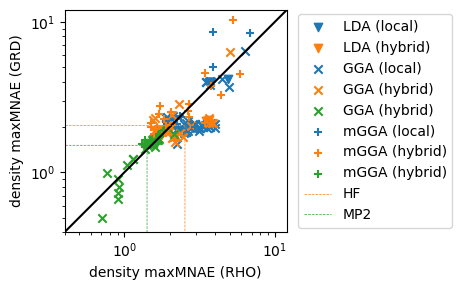

In [16]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot([1e-3, 1e2], [1e-3, 1e2], color="black")
ax.scatter(tab_err[mask_r3 & mask_lda ]["density maxMNAE"]["RHO"], tab_err[mask_r3 & mask_lda ]["density maxMNAE"]["GRD"], color="C0", marker="v", label= "LDA (local)")
ax.scatter(tab_err[mask_r4 & mask_lda ]["density maxMNAE"]["RHO"], tab_err[mask_r4 & mask_lda ]["density maxMNAE"]["GRD"], color="C1", marker="v", label= "LDA (hybrid)")
ax.scatter(tab_err[mask_r3 & mask_gga ]["density maxMNAE"]["RHO"], tab_err[mask_r3 & mask_gga ]["density maxMNAE"]["GRD"], color="C0", marker="x", label= "GGA (local)")
ax.scatter(tab_err[mask_r4 & mask_gga ]["density maxMNAE"]["RHO"], tab_err[mask_r4 & mask_gga ]["density maxMNAE"]["GRD"], color="C1", marker="x", label= "GGA (hybrid)")
ax.scatter(tab_err[mask_r5 & mask_gga ]["density maxMNAE"]["RHO"], tab_err[mask_r5 & mask_gga ]["density maxMNAE"]["GRD"], color="C2", marker="x", label= "GGA (hybrid)")
ax.scatter(tab_err[mask_r3 & mask_mgga]["density maxMNAE"]["RHO"], tab_err[mask_r3 & mask_mgga]["density maxMNAE"]["GRD"], color="C0", marker="+", label="mGGA (local)")
ax.scatter(tab_err[mask_r4 & mask_mgga]["density maxMNAE"]["RHO"], tab_err[mask_r4 & mask_mgga]["density maxMNAE"]["GRD"], color="C1", marker="+", label="mGGA (hybrid)")
ax.scatter(tab_err[mask_r5 & mask_mgga]["density maxMNAE"]["RHO"], tab_err[mask_r5 & mask_mgga]["density maxMNAE"]["GRD"], color="C2", marker="+", label="mGGA (hybrid)")

ax.plot([0, tab_err.loc["HF"]["density maxMNAE"]["RHO"]], tab_err.loc["HF"]["density maxMNAE"][["RHO", "GRD"]], color="C1", linewidth=0.5, linestyle="--", label="HF")
ax.plot(tab_err.loc["HF"]["density maxMNAE"][["RHO", "GRD"]], [tab_err.loc["HF"]["density maxMNAE"]["GRD"], 0], color="C1", linewidth=0.5, linestyle="--")

ax.plot([0, tab_err.loc["MP2"]["density maxMNAE"]["RHO"]], tab_err.loc["MP2"]["density maxMNAE"][["RHO", "GRD"]], color="C2", linewidth=0.5, linestyle="--", label="MP2")
ax.plot(tab_err.loc["MP2"]["density maxMNAE"][["RHO", "GRD"]], [tab_err.loc["MP2"]["density maxMNAE"]["GRD"], 0], color="C2", linewidth=0.5, linestyle="--")

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(0.4, 12)
ax.set_ylim(0.4, 12)
ax.set_aspect(1)

ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
ax.set_xlabel("density maxMNAE (RHO)")
ax.set_ylabel("density maxMNAE (GRD)")

fig.tight_layout()
fig.savefig("../compare-err-RHO-GRD.pdf", transparent=True)
fig.savefig("../compare-err-RHO-GRD.svg", transparent=True)

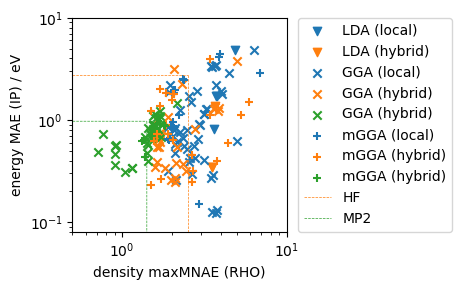

In [26]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter(tab_err[mask_r3 & mask_lda ]["density maxMNAE"]["RHO"], tab_err[mask_r3 & mask_lda ]["IP"]["MAE"], color="C0", marker="v", label= "LDA (local)")
ax.scatter(tab_err[mask_r4 & mask_lda ]["density maxMNAE"]["RHO"], tab_err[mask_r4 & mask_lda ]["IP"]["MAE"], color="C1", marker="v", label= "LDA (hybrid)")
ax.scatter(tab_err[mask_r3 & mask_gga ]["density maxMNAE"]["RHO"], tab_err[mask_r3 & mask_gga ]["IP"]["MAE"], color="C0", marker="x", label= "GGA (local)")
ax.scatter(tab_err[mask_r4 & mask_gga ]["density maxMNAE"]["RHO"], tab_err[mask_r4 & mask_gga ]["IP"]["MAE"], color="C1", marker="x", label= "GGA (hybrid)")
ax.scatter(tab_err[mask_r5 & mask_gga ]["density maxMNAE"]["RHO"], tab_err[mask_r5 & mask_gga ]["IP"]["MAE"], color="C2", marker="x", label= "GGA (hybrid)")
ax.scatter(tab_err[mask_r3 & mask_mgga]["density maxMNAE"]["RHO"], tab_err[mask_r3 & mask_mgga]["IP"]["MAE"], color="C0", marker="+", label="mGGA (local)")
ax.scatter(tab_err[mask_r4 & mask_mgga]["density maxMNAE"]["RHO"], tab_err[mask_r4 & mask_mgga]["IP"]["MAE"], color="C1", marker="+", label="mGGA (hybrid)")
ax.scatter(tab_err[mask_r5 & mask_mgga]["density maxMNAE"]["RHO"], tab_err[mask_r5 & mask_mgga]["IP"]["MAE"], color="C2", marker="+", label="mGGA (hybrid)")

ax.plot([0, tab_err.loc["HF"]["density maxMNAE"]["RHO"]], tab_err.loc["HF"][[("density maxMNAE", "RHO"), ("IP", "MAE")]], color="C1", linewidth=0.5, linestyle="--", label="HF")
ax.plot(tab_err.loc["HF"][[("density maxMNAE", "RHO"), ("IP", "MAE")]], [tab_err.loc["HF"]["IP"]["MAE"], 0], color="C1", linewidth=0.5, linestyle="--")

ax.plot([0, tab_err.loc["MP2"]["density maxMNAE"]["RHO"]], tab_err.loc["MP2"][[("density maxMNAE", "RHO"), ("IP", "MAE")]], color="C2", linewidth=0.5, linestyle="--", label="MP2")
ax.plot(tab_err.loc["MP2"][[("density maxMNAE", "RHO"), ("IP", "MAE")]], [tab_err.loc["MP2"]["IP"]["MAE"], 0], color="C2", linewidth=0.5, linestyle="--")

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(0.5, 10)
ax.set_ylim(0.08, 10)
ax.set_box_aspect(1)

ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
ax.set_xlabel("density maxMNAE (RHO)")
ax.set_ylabel("energy MAE (IP) / eV")

fig.tight_layout()
# fig.savefig("../compare-err-RHO-GRD.pdf", transparent=True)

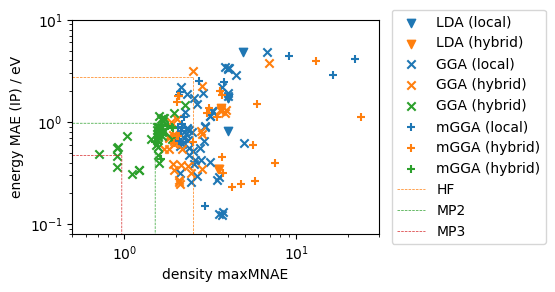

In [15]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter(tab_err[mask_r3 & mask_lda ]["density maxMNAE"].T.max(), tab_err[mask_r3 & mask_lda ]["IP"]["MAE"], color="C0", marker="v", label= "LDA (local)")
ax.scatter(tab_err[mask_r4 & mask_lda ]["density maxMNAE"].T.max(), tab_err[mask_r4 & mask_lda ]["IP"]["MAE"], color="C1", marker="v", label= "LDA (hybrid)")
ax.scatter(tab_err[mask_r3 & mask_gga ]["density maxMNAE"].T.max(), tab_err[mask_r3 & mask_gga ]["IP"]["MAE"], color="C0", marker="x", label= "GGA (local)")
ax.scatter(tab_err[mask_r4 & mask_gga ]["density maxMNAE"].T.max(), tab_err[mask_r4 & mask_gga ]["IP"]["MAE"], color="C1", marker="x", label= "GGA (hybrid)")
ax.scatter(tab_err[mask_r5 & mask_gga ]["density maxMNAE"].T.max(), tab_err[mask_r5 & mask_gga ]["IP"]["MAE"], color="C2", marker="x", label= "GGA (hybrid)")
ax.scatter(tab_err[mask_r3 & mask_mgga]["density maxMNAE"].T.max(), tab_err[mask_r3 & mask_mgga]["IP"]["MAE"], color="C0", marker="+", label="mGGA (local)")
ax.scatter(tab_err[mask_r4 & mask_mgga]["density maxMNAE"].T.max(), tab_err[mask_r4 & mask_mgga]["IP"]["MAE"], color="C1", marker="+", label="mGGA (hybrid)")
ax.scatter(tab_err[mask_r5 & mask_mgga]["density maxMNAE"].T.max(), tab_err[mask_r5 & mask_mgga]["IP"]["MAE"], color="C2", marker="+", label="mGGA (hybrid)")

ax.plot([0, tab_err.loc["HF"]["density maxMNAE"].T.max()], [tab_err.loc["HF"]["density maxMNAE"].T.max(), tab_err.loc["HF"][("IP", "MAE")]], color="C1", linewidth=0.5, linestyle="--", label="HF")
ax.plot([tab_err.loc["HF"]["density maxMNAE"].T.max(), tab_err.loc["HF"][("IP", "MAE")]], [tab_err.loc["HF"]["IP"]["MAE"], 0], color="C1", linewidth=0.5, linestyle="--")

ax.plot([0, tab_err.loc["MP2"]["density maxMNAE"].T.max()], [tab_err.loc["MP2"]["density maxMNAE"].T.max(), tab_err.loc["MP2"][("IP", "MAE")]], color="C2", linewidth=0.5, linestyle="--", label="MP2")
ax.plot([tab_err.loc["MP2"]["density maxMNAE"].T.max(), tab_err.loc["MP2"][("IP", "MAE")]], [tab_err.loc["MP2"]["IP"]["MAE"], 0], color="C2", linewidth=0.5, linestyle="--")

ax.plot([0, tab_err.loc["MP3"]["density maxMNAE"].T.max()], [tab_err.loc["MP3"]["density maxMNAE"].T.max(), tab_err.loc["MP3"][("IP", "MAE")]], color="C3", linewidth=0.5, linestyle="--", label="MP3")
ax.plot([tab_err.loc["MP3"]["density maxMNAE"].T.max(), tab_err.loc["MP3"][("IP", "MAE")]], [tab_err.loc["MP3"]["IP"]["MAE"], 0], color="C3", linewidth=0.5, linestyle="--")

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(0.5, 30)
ax.set_ylim(0.08, 10)
ax.set_box_aspect(0.7)

ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
ax.set_xlabel("density maxMNAE")
ax.set_ylabel("energy MAE (IP) / eV")

fig.tight_layout()
fig.savefig("../compare-err-maxMNAE-MAEIP.pdf", transparent=True)
fig.savefig("../compare-err-maxMNAE-MAEIP.svg", transparent=True)

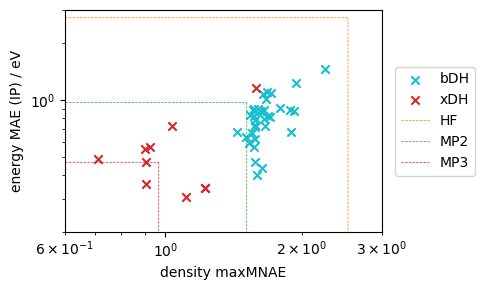

In [25]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.scatter(tab_err[mask_bdh]["density maxMNAE"].T.max(), tab_err[mask_bdh]["IP"]["MAE"], color="C9", marker="x", label= "bDH")
ax.scatter(tab_err[mask_xdh]["density maxMNAE"].T.max(), tab_err[mask_xdh]["IP"]["MAE"], color="C3", marker="x", label= "xDH")

ax.plot([0, tab_err.loc["HF"]["density maxMNAE"].T.max()], [tab_err.loc["HF"]["density maxMNAE"].T.max(), tab_err.loc["HF"][("IP", "MAE")]], color="C1", linewidth=0.5, linestyle="--", label="HF")
ax.plot([tab_err.loc["HF"]["density maxMNAE"].T.max(), tab_err.loc["HF"][("IP", "MAE")]], [tab_err.loc["HF"]["IP"]["MAE"], 0], color="C1", linewidth=0.5, linestyle="--")

ax.plot([0, tab_err.loc["MP2"]["density maxMNAE"].T.max()], [tab_err.loc["MP2"]["density maxMNAE"].T.max(), tab_err.loc["MP2"][("IP", "MAE")]], color="C2", linewidth=0.5, linestyle="--", label="MP2")
ax.plot([tab_err.loc["MP2"]["density maxMNAE"].T.max(), tab_err.loc["MP2"][("IP", "MAE")]], [tab_err.loc["MP2"]["IP"]["MAE"], 0], color="C2", linewidth=0.5, linestyle="--")

ax.plot([0, tab_err.loc["MP3"]["density maxMNAE"].T.max()], [tab_err.loc["MP3"]["density maxMNAE"].T.max(), tab_err.loc["MP3"][("IP", "MAE")]], color="C3", linewidth=0.5, linestyle="--", label="MP3")
ax.plot([tab_err.loc["MP3"]["density maxMNAE"].T.max(), tab_err.loc["MP3"][("IP", "MAE")]], [tab_err.loc["MP3"]["IP"]["MAE"], 0], color="C3", linewidth=0.5, linestyle="--")

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(0.6, 3)
ax.set_ylim(0.2, 3)
ax.set_box_aspect(0.7)

ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
ax.set_xlabel("density maxMNAE")
ax.set_ylabel("energy MAE (IP) / eV")

fig.tight_layout()
fig.savefig("../compare-err-maxMNAE-MAEIP-dh.pdf", transparent=True)
fig.savefig("../compare-err-maxMNAE-MAEIP-dh.svg", transparent=True)

In [180]:
tab_err[~mask_wft]["IP"]["MAE"].sort_values()[:10]

functional
PBELYP       0.121795
mPWLYP1w     0.124598
PW91LYP      0.131271
TPSSLYP1w    0.152020
M06-2X       0.232841
M08-SO       0.245114
B3LYPV1R     0.248670
RPBE         0.257088
mPW1LYP      0.260684
M05          0.265551
Name: MAE, dtype: float64

In [181]:
tab_err["density maxMNAE"].T.max()[tab_err[~mask_wft]["IP"]["MAE"].sort_values()[:10].index]

functional
PBELYP       3.706911
mPWLYP1w     3.529048
PW91LYP      3.763419
TPSSLYP1w    2.934510
M06-2X       4.213742
M08-SO       4.783833
B3LYPV1R     2.108666
RPBE         2.451630
mPW1LYP      2.068790
M05          5.766840
dtype: float64

In [199]:
tab_err["density maxMNAE"].T.max().sort_values()

functional
CCSD           0.000000
MP4(SDQ)       0.245539
revXYGJ-OS     0.712013
XYG6           0.901323
xDH-PBE0       0.906552
                ...    
MN12-L         8.994762
MN12-SX       13.004112
M11-L         16.267592
MN15-L        21.819811
MN15          23.795075
Length: 178, dtype: float64

In [203]:
tab_err[("IP", "MAE")].T.sort_values()[-20:]

functional
M06-SX      1.990576
Becke       2.178754
OPTX        2.214999
ωB97        2.258392
revM06-L    2.446788
M06-L       2.530564
HF          2.729346
SLYP        2.889052
M11-L       2.909092
ωB97X       3.130847
SPW91       3.292137
SOP         3.354008
SPBE        3.390582
SP86        3.424585
N12-SX      3.762895
MN12-SX     3.955841
MN15-L      4.177324
MN12-L      4.412767
Slater      4.792929
N12         4.841616
Name: (IP, MAE), dtype: float64

In [228]:
tab_err["density maxMNAE"].T[tab_err["density maxMNAE"].T.max().sort_values()[:20].index].T

,RHO,GRD,LR
functional,,,
CCSD,0.000000,0.000000,0.000000
MP4(SDQ),0.245539,0.233093,0.161640
revXYGJ-OS,0.712013,0.499853,0.320192
XYG6,0.901323,0.665436,0.444908
xDH-PBE0,0.906552,0.897644,0.668525
XYGJ-OS,0.907952,0.733366,0.674218
XYG5,0.923516,0.802816,0.519950
MP3,0.881324,0.967352,0.718420
XYGJ-OS5,0.771090,0.995833,1.032277


## Functional Numbers Plot

In [230]:
mask_r3.sum(), mask_r4.sum(), mask_r5.sum()

(71, 58, 44)

In [231]:
(mask_r3 & mask_lda).sum(), (mask_r3 & mask_gga).sum(), (mask_r3 & mask_mgga).sum()

(4, 49, 18)

In [232]:
(mask_r4 & mask_lda).sum(), (mask_r4 & mask_gga).sum(), (mask_r4 & mask_mgga).sum()

(3, 32, 23)

In [236]:
(mask_r5 & mask_xdh).sum(), (mask_r5 & mask_gga & mask_bdh).sum(), (mask_r5 & mask_mgga & mask_bdh).sum()

(10, 28, 6)

In [20]:
cm20 = plt.colormaps["tab20c"]

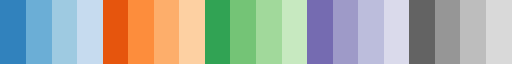

In [21]:
cm20

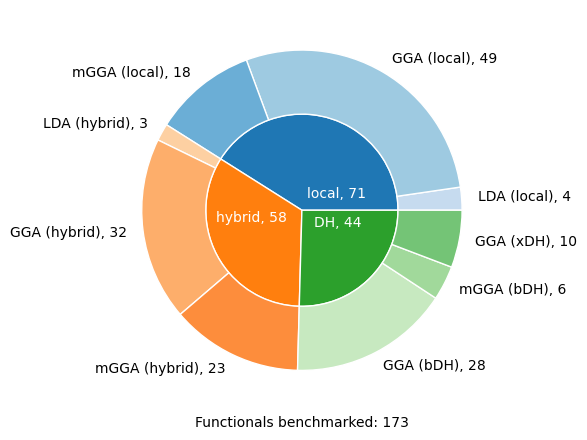

In [22]:
fig, ax = plt.subplots(figsize=(6, 4.5))

ax.pie(
    [71, 58, 44], labels=["local, 71", "hybrid, 58", "DH, 44"],
    radius=0.6,
    wedgeprops=dict(width=0.6, edgecolor='w'),
    labeldistance=0.18, textprops={"color": "w"})
ax.pie(
    [4, 49, 18, 3, 32, 23, 28, 6, 10],
    labels=[
        "LDA (local), 4",
        "GGA (local), 49",
        "mGGA (local), 18",
        "LDA (hybrid), 3",
        "GGA (hybrid), 32",
        "mGGA (hybrid), 23",
        "GGA (bDH), 28",
        "mGGA (bDH), 6",
        "GGA (xDH), 10",],
    radius=1,
    colors=cm20([3, 2, 1, 7, 6, 5, 11, 10, 9]),
    wedgeprops=dict(width=0.4, edgecolor='w'))
ax.set_xlabel("Functionals benchmarked: 173")
fig.tight_layout()
fig.savefig("../functionals-distribution.pdf", transparent=True)
fig.savefig("../functionals-distribution.svg", transparent=True)

## Reproduce Fig. 1 of PNAS

In [23]:
# functionals to be included
xc_list = [
    "CCSD", "MP4(SDQ)", "MP3", "MP2", "HF",
    # rung 1-3
    "TPSS", "RSCAN", "R4SCAN", "PBE", "BLYP", "PBELYP", "mPWLYP1w",
    # rung 4
    "BHHLYP", "APFD", "PBE0", "M06-2X", "B3LYPV1R", "X3LYP", "O3LYP", "TPSSh", "R4SCAN0", "GAS22",
    # rung 5
    "revXYGJ-OS", "XYG6", "xDH-PBE0", "revXYG3", "XYGJ-OS", "DSD-PBEPBE-D3BJ", "DSD-BLYP-D3BJ", "SOS-RSX-PBE-QIDH", "RS-PBE-PBE", "B2PLYP",
    # something emmm
    "M11-L", "M11", "MN15-L", "MN15",
]

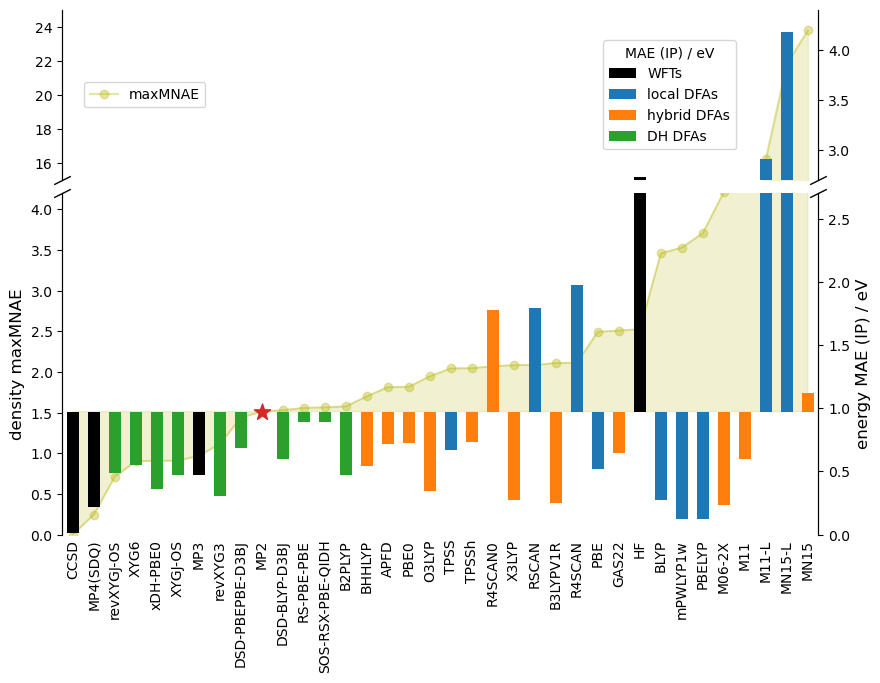

In [24]:
t_err = tab_err.loc[xc_list]
t_err = pd.concat([t_err["density maxMNAE"].T.max(), t_err[("IP", "MAE")]], axis=1)
t_err.columns = ["RDF maxMNAE", "IP MAE"]
t_err = t_err.sort_values("RDF maxMNAE")
t_err["rank"] = range(len(t_err.index))

fig, axs = plt.subplots(2, 1, figsize=(9, 7), sharex=True, gridspec_kw={"hspace": 0.05, "height_ratios": [1, 2]})
bxs = [axs[0].twinx(), axs[1].twinx()]

for ax in axs:
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.tick_params(axis="x", length=0)
    ax.fill_between(t_err["rank"], t_err["RDF maxMNAE"], [t_err["RDF maxMNAE"]["MP2"]] * len(t_err.index), color="C8", alpha=0.2)
    ax.plot(t_err["rank"], t_err["RDF maxMNAE"], color="C8", alpha=0.4, marker="o", label="maxMNAE")
    ax.scatter(t_err.loc["MP2"]["rank"], t_err.loc["MP2"]["RDF maxMNAE"], color="C3", marker="*", s=150, zorder=10)

for bx in bxs:
    bx.spines.top.set_visible(False)
    bx.spines.bottom.set_visible(False)
    bx.tick_params(axis="x", length=0)
    for mask, color, label in [
            (mask_wft, "black", "WFTs"),
            (mask_r3, "C0", "local DFAs"),
            (mask_r4, "C1", "hybrid DFAs"),
            (mask_r5, "C2", "DH DFAs")]:
        bx.bar(t_err.loc[mask]["rank"], t_err.loc[mask]["IP MAE"] - t_err["IP MAE"]["MP2"], bottom=t_err["IP MAE"]["MP2"], width=0.6, color=color, label=label)
# limits
axs[0].set_xlim(-0.5, len(t_err.index) - 1 + 0.5)
axs[1].set_ylim(0, 4.2)
axs[0].set_ylim(15, 25)
mp2_ratio = t_err["IP MAE"]["MP2"] / t_err["RDF maxMNAE"]["MP2"]
bxs[1].set_ylim(0, mp2_ratio * 4.2)
bxs[0].set_ylim(2.7, 4.4)
# ticks
axs[1].set_xticklabels(t_err.index, rotation=90)
axs[1].set_xticks(t_err["rank"])
kwargs = dict(marker=[(-1, -0.5), (1, 0.5)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
# additional
axs[0].plot([0, 1], [0, 0], transform=axs[0].transAxes, **kwargs)
axs[1].plot([0, 1], [1, 1], transform=axs[1].transAxes, **kwargs)
axs[1].set_ylabel("density maxMNAE", fontsize=12)
bxs[1].set_ylabel("energy MAE (IP) / eV", fontsize=12)
axs[0].legend(loc="center left", bbox_to_anchor=(0.02, 0.5))
bxs[0].legend(loc="center right", bbox_to_anchor=(0.9, 0.5), title="MAE (IP) / eV")
fig.tight_layout()
fig.subplots_adjust(bottom=0.23, top=0.98, left=0.08, right=0.92)
fig.savefig("../compare-err-relative.pdf", transparent=True)
fig.savefig("../compare-err-relative.svg", transparent=True)